In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_train_data = "data_set/train.csv"

origin_data = utils.load_csv_data(path_train_data)
# Debugging: Check the type of train_data

# Print the loaded data
if isinstance(origin_data, pd.DataFrame):
    print(f"dimension train data: {origin_data.shape}")
else:
    print("train_data is not a DataFrame")

Successfully loaded data from data_set/train.csv
dimension train data: (1460, 81)


create target data


In [3]:
# Get train data
y_train = origin_data["SalePrice"]
print(y_train.shape)


# Drop the Id and sales price column
train_data = origin_data.drop(columns=["Id"]).drop(columns=["SalePrice"])
print(train_data.shape)

print(type(origin_data))
# Check the shape of x_train and y_train
print(f"x_train shape: {train_data.shape}")
print(f"y_train shape: {y_train.shape}")

(1460,)
(1460, 79)
<class 'pandas.core.frame.DataFrame'>
x_train shape: (1460, 79)
y_train shape: (1460,)


In [4]:
train_data = utils.auto_clean_columns(train_data)

Convert dataset with OneHotEncoder


In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


def prepare_features(x_data_frame: pd.DataFrame):
    """
    X_train = vstupní featury (normalizované, zakódované, připravené)
    y_train = cílová hodnota (ve tvém případě MSSubClass)
    transformer = pipeline pro použití na testovacích datech
    """
    X = x_data_frame.copy()

    # # 1. Rozdělení cílové proměnné a vstupů
    # y = df[target_column]

    # 2. Rozdělení sloupců
    numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

    # 3. Tvorba transformací
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_cols),
            (
                "cat",
                OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                categorical_cols,
            ),
        ]
    )

    # 4. Pipeline (můžeš použít i s modely jako XGBoost, NN atd.)
    pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

    # 5. Fit + transform vstupní data
    X_transformed = pipeline.fit_transform(X)

    # 6. Získání názvů nových sloupců (volitelné)
    new_columns = []

    if numerical_cols:
        new_columns += numerical_cols

    if categorical_cols:
        encoder = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
        new_columns += encoder.get_feature_names_out(categorical_cols).tolist()

    X_transformed_df = pd.DataFrame(X_transformed, columns=new_columns, index=X.index)

    return X_transformed_df, pipeline  # X, y, transformer pro testovací data

- X_train = vstupní featury (normalizované, zakódované, připravené)
- y_train = cílová hodnota (ve tvém případě MSSubClass)
- transformer = pipeline pro použití na testovacích datech


In [6]:
x_train, transformer = prepare_features(train_data)
# print(transformer)
print(f"train_data shape: {train_data.shape}")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(type(x_train))
print(type(y_train))

train_data shape: (1460, 79)
x_train shape: (1460, 304)
y_train shape: (1460,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


## Prepare test data with transformer


In [ ]:
path_test_data = "data_set/test.csv"

test_data = utils.load_csv_data(path_test_data)
# Debugging: Check the type of test_data

# Print the loaded data
if isinstance(test_data, pd.DataFrame):
    print(f"dimension train data: {test_data.shape}")
else:
    print("test_data is not a DataFrame")
print(type(test_data))

In [ ]:
test_data = test_data.drop(columns=["Id"])
print(test_data.shape)
test_data = utils.auto_clean_columns(test_data)
# test_data = test_data.replace("NA", np.nan)
print(type(test_data))

In [ ]:
x_target = transformer.transform(test_data)
print(type(x_target))

prepare test targets


In [ ]:
path_target_data = "data_set/sample_submission.csv"

target_data = utils.load_csv_data(path_target_data)
# Debugging: Check the type of test_data

# Print the loaded data
if isinstance(target_data, pd.DataFrame):
    print(f"dimension train data: {target_data.shape}")
else:
    print("test_data is not a DataFrame")

In [ ]:
y_target = target_data.drop(columns=["Id"])

In [ ]:
print(x_target.shape)
print(y_target.shape)
print(type(x_target))
print(type(y_target))

In [ ]:
# # Se jmény sloupců z transformace
# num_cols = transformer.named_steps["preprocessor"].transformers_[0][2]
# cat_encoder = transformer.named_steps["preprocessor"].named_transformers_["cat"]
# cat_cols = cat_encoder.get_feature_names_out(
#     transformer.named_steps["preprocessor"].transformers_[1][2]
# )

# all_cols = list(num_cols) + list(cat_cols)

# # Převod na DataFrame
# import pandas as pd

# x_target = pd.DataFrame(x_target, columns=all_cols, index=test_data.index)
# print(type(y_target))

# Create and Train model


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_target.shape)
print(y_target.shape)

In [ ]:
print(type(x_train))
print(type(y_train))
print(type(x_target))
print(type(y_target))

In [ ]:
# Convert pd.DataFrame to np.ndarray
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

# x_target = x_target.to_numpy()
y_target = y_target.to_numpy()

In [ ]:
num_val_samples = len(x_train)
print(num_val_samples)

samples_target = num_val_samples * 4 // 5
print(samples_target)

val_data = x_train[:samples_target]
val_targets = y_train[samples_target:]

In [ ]:
i = 0

k = 4
num_val_samples = len(x_train) // k
print(num_val_samples)
print(f"processing fold # {i}")
print(target_data.shape)
val_data = x_train[i * num_val_samples : (i + 1) * num_val_samples]
val_targets = y_train[i * num_val_samples : (i + 1) * num_val_samples]
print(val_data.shape)
print(val_targets.shape)

partial_train_data = pd.concat(
    [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]]
)
partial_train_targets = pd.concat(
    [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]]
)
print(partial_train_data.shape)
print(partial_train_targets.shape)
# print(partial_train_data.shape)
print(x_train.shape[1])

### K Fold validation

In [ ]:
import keras
import time

start = time.time()


def build_model(input_parameters):
    input_shape = (input_parameters,)  # 304 parameters of house
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(838, activation="relu", input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(1600, activation="relu"))
    model.add(keras.layers.Dense(1))  # regresní výstup
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


k = 1
num_val_samples = len(x_train) // k
num_epochs = 10
all_scores = []
all_histories = []


for i in range(k):
    print(f"processing fold # {i}")
    val_data = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples : (i + 1) * num_val_samples]
    partial_train_data = pd.concat(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]]
    )
    partial_train_targets = pd.concat(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]]
    )

    model = build_model(x_train.shape[1])
    print("- 🧠 Spouštím trénování...")
    history = model.fit(
        partial_train_data,
        partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs,
        batch_size=64,
        verbose=0,
    )

    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    print(f"- ✅ Fold {i + 1} finished: val_mae = {val_mae:.2f}")
    _ = utils.plot_history(history.history, metric="mae")
    all_scores.append(val_mae)
    all_histories.append(history)

print(all_scores)
print(f"🕒 Celkový čas trénování: {time.time() - start:.2f} s")

In [ ]:
# Rozdělení před přípravou
train_df, val_df = train_test_split(origin_data, test_size=0.2, random_state=42)

# y
y_train = train_df["SalePrice"].to_numpy()
y_val = val_df["SalePrice"].to_numpy()

# X (bez 'Id' a 'SalePrice')
train_data = train_df.drop(columns=["Id", "SalePrice"])
val_data = val_df.drop(columns=["Id", "SalePrice"])

# Čištění
train_data_clean = utils.auto_clean_columns(train_data)
val_data_clean = utils.auto_clean_columns(val_data)

# Feature preparation
x_train, transformer = prepare_features(train_data_clean)
x_val = transformer.transform(val_data_clean)

In [ ]:
print(np.isnan(x_val).sum())  # musí být 0

61


C:\Users\Libor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- ✅ finished: val_mae = 59327.77


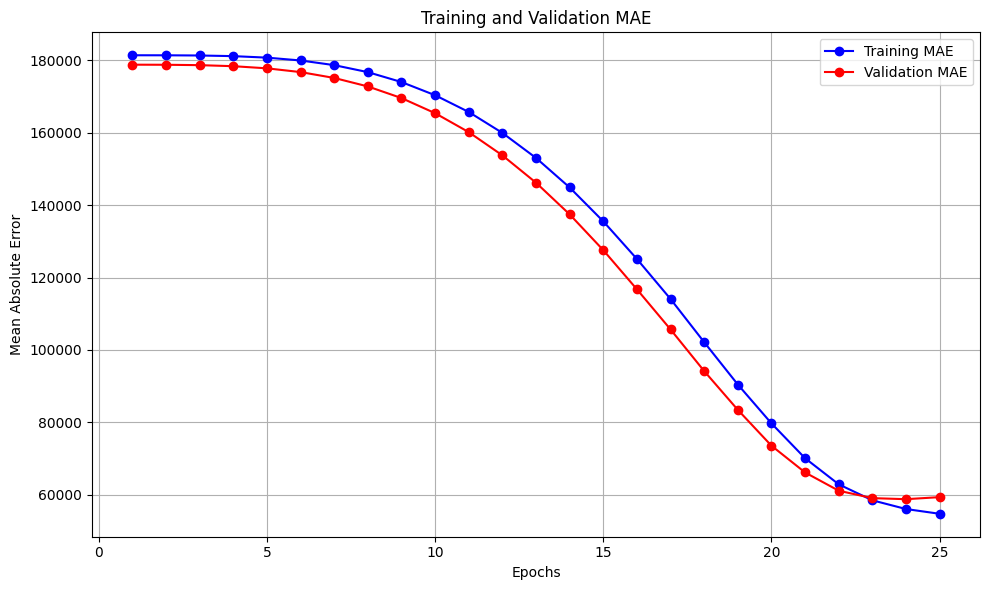

59327.7734375
🕒 Celkový čas trénování: 8.23 s


In [10]:
from sklearn.model_selection import train_test_split
import keras
import time

start = time.time()


def build_model(input_parameters):
    input_shape = (input_parameters,)  # 304 parameters of house
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(838, activation="relu", input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(838, activation="relu"))
    model.add(keras.layers.Dense(1))  # regresní výstup
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


num_epochs = 25

x_train_part, x_val, y_train_part, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

model = build_model(x_train.shape[1])
history = model.fit(
    x_train_part,
    y_train_part,
    epochs=num_epochs,
    batch_size=64,
    validation_data=(x_val, y_val),
    verbose=0,
)


val_mse, val_mae = model.evaluate(x_val, y_val, verbose=0)
print(f"- ✅ finished: val_mae = {val_mae:.2f}")
_ = utils.plot_history(history.history, metric="mae")

print(val_mae)
print(f"🕒 Celkový čas trénování: {time.time() - start:.2f} s")

In [ ]:
model.save("house_prices_oneSotEncoder.keras")

Test on train data

Min: 34,900 USD
Max: 755,000 USD
Mean: 180,921 USD
diff = 45,750 USD | prediction = 162,749 USD | target = 208,500 USD
diff = 18,750 USD | prediction = 162,749 USD | target = 181,500 USD
diff = 60,750 USD | prediction = 162,749 USD | target = 223,500 USD
diff = -22,749 USD | prediction = 162,749 USD | target = 140,000 USD
diff = 87,250 USD | prediction = 162,749 USD | target = 250,000 USD
diff = -19,749 USD | prediction = 162,749 USD | target = 143,000 USD
diff = 144,250 USD | prediction = 162,749 USD | target = 307,000 USD
diff = 37,250 USD | prediction = 162,749 USD | target = 200,000 USD
diff = -32,849 USD | prediction = 162,749 USD | target = 129,900 USD
diff = -44,749 USD | prediction = 162,749 USD | target = 118,000 USD

min_diff = -44,749 USD |
max_diff = 144,250 USD |


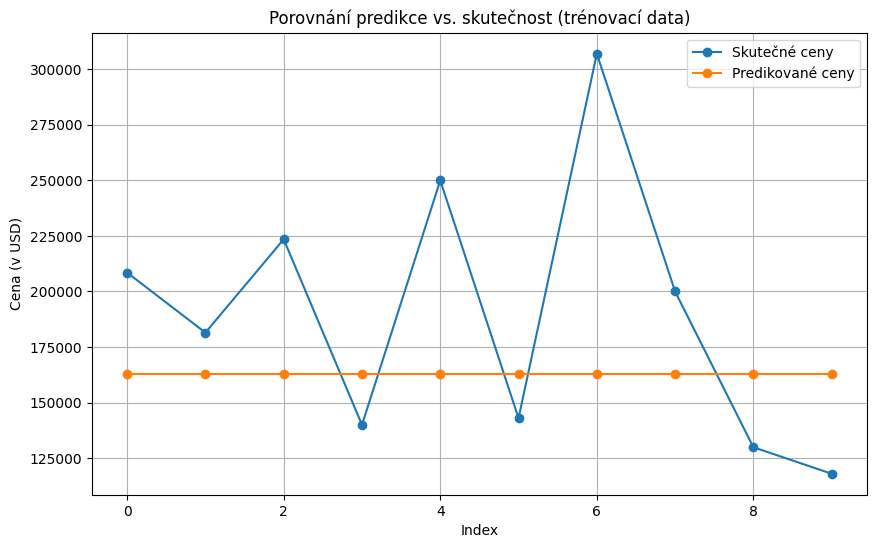

In [13]:
import matplotlib.pyplot as plt

print(f"Min: {y_train.min():,.0f} USD")
print(f"Max: {y_train.max():,.0f} USD")
print(f"Mean: {y_train.mean():,.0f} USD")

max_diff = 0
min_diff = 0
count = 10  # nebo x_train.shape[0] podle potřeby

for i in range(count):
    features = x_train[i].reshape(1, -1)
    prediction = model.predict(features, verbose=0)[0][0]
    true_value = y_train[i]

    diff = int(true_value - prediction)
    pred_int = int(prediction)
    true_int = int(true_value)

    if diff > max_diff:
        max_diff = diff
    elif diff < min_diff:
        min_diff = diff

    print(
        f"diff = {format(diff, ',')} USD | "
        f"prediction = {format(pred_int, ',')} USD | "
        f"target = {format(true_int, ',')} USD"
    )

print(
    f"\nmin_diff = {format(min_diff, ',')} USD |"
    f"\nmax_diff = {format(max_diff, ',')} USD |"
)

# Výpočet predikcí a graf
preds = [
    model.predict(x_train[i].reshape(1, -1), verbose=0)[0][0] for i in range(count)
]
trues = y_train[:count]

plt.figure(figsize=(10, 6))
plt.plot(trues, marker="o", label="Skutečné ceny")
plt.plot(preds, marker="o", label="Predikované ceny")
plt.title("Porovnání predikce vs. skutečnost (trénovací data)")
plt.xlabel("Index")
plt.ylabel("Cena (v USD)")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(x_train[:5])

[[ 0.07337496 -0.20803433 -0.20714171 ...  0.          1.
   0.        ]
 [-0.87256276  0.40989452 -0.09188637 ...  0.          1.
   0.        ]
 [ 0.07337496 -0.08444856  0.07347998 ...  0.          1.
   0.        ]
 [ 0.30985939 -0.41401061 -0.09689747 ...  0.          0.
   0.        ]
 [ 0.07337496  0.57467554  0.37514829 ...  0.          1.
   0.        ]]


In [12]:
print(np.std(x_train, axis=0))  # směrodatná odchylka po sloupcích

[1.                nan 1.         1.         1.         1.
 1.                nan 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
        nan 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.08247668 0.20624856 0.10410959 0.40847365 0.35639876 0.06397422
 0.06397422 0.18186189 0.24175172 0.16520769 0.47075477 0.16520769
 0.08247668 0.48183118 0.20319622 0.18186189 0.15507914 0.30272036
 0.02616223 0.02616223 0.38430151 0.24543496 0.17650912 0.05227064
 0.44872999 0.22487878 0.20624856 0.09394055 0.10727654 0.0369863
 0.10410959 0.1953148  0.13715059 0.30361863 0.18360636 0.25259026
 0.22623382 0.15716305 0.10727654 0.18009792 0.36105377 0.16520769
 0.07827122 0.22351342 0.21794495 0.26722074 0.21935353 0.19692108
 0.23544514 0.1297308  0.1297308  0.15921674 0.08647243 0.17831386
 0.2289137  0.34383289 0.07382024 0.11333288

In [ ]:
print(np.min(x_train, axis=0))
print(np.max(x_train, axis=0))
print(np.mean(x_train, axis=0))
print(np.std(x_train, axis=0))

# ruin model on target data

In [ ]:
print(type(x_train))
print(type(y_train))
print(type(x_target))
print(type(y_target))
print(x_train.shape)
print(y_train.shape)
print(x_target.shape)
print(y_target.shape)

In [ ]:
import matplotlib.pyplot as plt

print(f"Min: {y_target.min():,.0f} USD")
print(f"Max: {y_target.max():,.0f} USD")
print(f"Mean: {y_target.mean():,.0f} USD")

max_diff = 0
min_diff = 0
count = 10  # nebo x_target.shape[0] podle potřeby

for i in range(count):
    features = x_target[i].reshape(1, -1)  # bez .iloc
    prediction = model.predict(features, verbose=0)[0][0]
    target_value = y_target[i]

    diff = int(target_value - prediction)
    pred_int = int(prediction)
    target_int = int(target_value)

    if diff > max_diff:
        max_diff = diff
    elif diff < min_diff:
        min_diff = diff

    print(
        f"diff = {format(diff, ',')} USD | "
        f"prediction = {format(pred_int, ',')} USD | "
        f"target = {format(target_int, ',')} USD"
    )

print(
    f"\nmin_diff = {format(min_diff, ',')} USD |"
    f"\nmax_diff = {format(max_diff, ',')} USD |"
)

# Výpočet predikcí a vykreslení grafu
preds = [
    model.predict(x_target[i].reshape(1, -1), verbose=0)[0][0] for i in range(count)
]
trues = y_target[:count]

plt.figure(figsize=(10, 6))
plt.plot(trues, marker="o", label="Skutečné ceny")
plt.plot(preds, marker="o", label="Predikované ceny")
plt.title("Porovnání predikce vs. skutečnost")
plt.xlabel("Index")
plt.ylabel("Cena (v USD)")
plt.legend()
plt.grid(True)
plt.show()

# other

In [ ]:
print("\n" + "=" * 50)
print("📊 Výsledky cross-validace:")
for i, score in enumerate(all_scores):
    print(f"Fold {i + 1}: MAE = {score:.2f}")

average = np.mean(all_scores)
print("-" * 50)
print(f"📈 Průměrná MAE přes {k} foldů: {average:.2f}")

epoch_maes = [
    [history.history["mae"][epoch] for history in all_histories]
    for epoch in range(num_epochs)
]
average_mae_history = [np.mean(epoch) for epoch in epoch_maes]
std_mae_history = [np.std(epoch) for epoch in epoch_maes]

plt.figure(figsize=(10, 6))
plt.plot(
    range(1, num_epochs + 1), average_mae_history, marker="o", label="Průměrná MAE"
)
plt.fill_between(
    range(1, num_epochs + 1),
    np.array(average_mae_history) - np.array(std_mae_history),
    np.array(average_mae_history) + np.array(std_mae_history),
    alpha=0.2,
    label="± 1 std",
)
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("📈 Průměrná MAE s rozptylem (všechny foldy)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
for i in range(10):
    predictions = model.predict(x_target.iloc[[i]], verbose=0)
    target_value = y_target.iloc[i]

    diff = int(target_value - predictions[0][0])
    pred = int(predictions[0][0])
    target = int(target_value)

    print(
        f"diff = {format(diff, ',').replace(',', ' ')} USD | "
        f"prediction = {format(pred, ',').replace(',', ' ')} USD | "
        f"target = {format(target, ',').replace(',', ' ')} USD"
    )